# Model constants

## Memory constraints thus using LLaVa 7b only !

In [1]:
MAX_LENGTH = 384 # computed from the data analysis notebook
MODEL_ID = "llava-hf/llava-1.5-7b-hf"

# Since we are initially training the LLaVa model for vision-language alignment to establish 
# dataset utility
USE_LORA  = True
USE_QLORA = True

# Idea :

1. For the initial **adapter** training/alignment phase, I am planning to use all available text generated data.

1.5 : Directly use this CLIP + more conteztually aligned adapter for linear evaluation protocol to see whether domain specific modality alignment is beneficial or not ! 

2. Once I have aligned the frozen CLIP encoder with the frozen vicuna LLM, then unfreeze the vision encoder & freeze the adapter. Use the projected vision tokens + the descriptive text data to generate a final classification of : (GON/GVFD&GON) vs Healthy. [**Follow up would obviously be an unfrozen adapter**]
 
3. Once we have a good vision encoder from step 2. use the frozen vision encoder + frozen adapter with a trainable binary classifier on top : this forms your linear evaluation protocol.

# Basic Imports

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import PIL
from tqdm import tqdm
from nltk import edit_distance

# model related imports
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig, LlavaForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# reproducablity
seed = 100
np.random.seed(seed)
random.seed(seed)

/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-02 15:57:26.437027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-02 15:57:26.437077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-02 15:57:26.437999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 15:57:26.444161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This 

# Load & Visualise samples

In [3]:
fp = "/tscc/nfs/home/vejoshi/vlm_comparison/ret_found_baseline_non_vlm/RETFound_MAE/data_csv_file/processed_pretraining.csv"
df = pd.read_csv(fp)
df = df.iloc[0:1000]
df.head()

,Unnamed: 0,PatientID,ideye,OCTImagePath,TextDescriptionPath,Split,Eye,Age_at_SpectralisDate,gender,ethnicity,...,DiameterInDegrees,FixedInMM,Spectralis_RNFL_QCQualityScore,RevisedImageID,OCT_VF10_Date_Difference,Fundus_PhotoLocation,Fundus_PhotoFilename,Fundus_Date,OCT_Fundus_Date_Difference,label_sentence
0,0,AL0320,AL0320 OS,/tscc/projects/ps-visres-group/Bscans_for_vols...,/tscc/projects/ps-visres-group/MM-LLM/descript...,train,L,55.852156,Female,Not Hispanic,...,12.0,0,Correct,26133_4,2.091718,DODRC/AL0320,AL0320_2012_07_25_OS_02.JPG,7/25/12,0.000000,This eye appears to have OHT.
1,1,AL0320,AL0320 OS,/tscc/projects/ps-visres-group/Bscans_for_vols...,/tscc/projects/ps-visres-group/MM-LLM/descript...,train,L,55.852156,Female,Not Hispanic,...,12.0,0,Correct,26133_0,2.091718,DODRC/AL0320,AL0320_2012_07_25_OS_02.JPG,7/25/12,0.000000,The scan results suggest OHT for this eye.
2,2,AL0320,AL0320 OS,/tscc/projects/ps-visres-group/Bscans_for_vols...,/tscc/projects/ps-visres-group/MM-LLM/descript...,train,L,55.852156,Female,Not Hispanic,...,12.0,0,Correct,26133_2,2.091718,DODRC/AL0320,AL0320_2012_07_25_OS_02.JPG,7/25/12,0.000000,There is OHT seen in this eye scan.
3,3,AL0320,AL0320 OS,/tscc/projects/ps-visres-group/Bscans_for_vols...,/tscc/projects/ps-visres-group/MM-LLM/descript...,train,L,56.443532,Female,Not Hispanic,...,12.0,0,Correct,51301_0,1.500342,DODRC/AL0320,AL0320_2012_07_25_OS_02.JPG,7/25/12,0.591376,"Based on the scan, there is evidence of OHT."
4,4,AL0320,AL0320 OS,/tscc/projects/ps-visres-group/Bscans_for_vols...,/tscc/projects/ps-visres-group/MM-LLM/descript...,train,L,56.443532,Female,Not Hispanic,...,12.0,0,Correct,51302_0,1.500342,DODRC/AL0320,AL0320_2012_07_25_OS_02.JPG,7/25/12,0.591376,"Based on the scan, the condition of the eye is..."


In [4]:
df["EyeDX_at_spectralisDate"].value_counts()

EyeDX_at_spectralisDate
OHT           280
Healthy       264
GVFD & GON    206
GON           175
GVFD           75
Name: count, dtype: int64

Label           :  Healthy
-----------
Sentence format  :  The scan of this eye shows a Healthy condition.
-----------
Text in dataset :  Patient is a 56 year old Non-Hispanic, Black <SEX> with  with no eye disease.. IOP is 14.0 mmHg, CCT is 500.7 mm, spherical equivalent is 0.0 diopters. Patient has history of High Cholesterol, Allergy, Asthma, High Blood Pressure, and Diabetes - Type Unspecified

ONH OCT is unusable due to quality and/or segmentation issues.

Patient has an MD = 0.33 dB (PSD = 1.15 dB) on recent, reliable 24-2 VF test. Functional loss in superior sector(s).

Structure - function correlation unknown because of OCT quality issues.




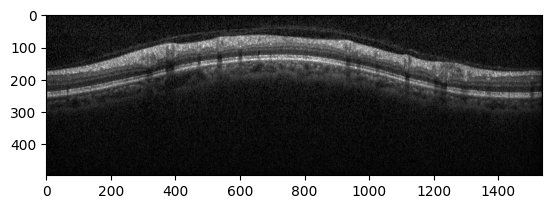

In [5]:
rand_ind = np.random.randint(0,len(df))
print("Label           : ",df.iloc[rand_ind]["EyeDX_at_spectralisDate"])
print("-----------")
print("Sentence format  : ",df.iloc[rand_ind]["label_sentence"])
print("-----------")
txt = ""
with open(df.iloc[rand_ind]["TextDescriptionPath"], 'r') as f:
    txt = f.read()
print("Text in dataset : ",txt)
plt.imshow(Image.open(df["OCTImagePath"].iloc[rand_ind]), cmap ="gray")
plt.show()

# Data loading

> **Hypothesis 1:** Do note that we load a model here which already has undergone supervised fine-tuning (SFT) on the LLaVa-Instruct-150K instruction dataset. We can benefit from the fine-tuning that the model already has undergone.


<br>

**Exp 1:** Only focused on adapter training. Rest all stuff is frozen & we see whether CLIP+adapter benefits from this descriptive data.

In [6]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


# LoRa-Implementation for future.....

In [7]:
## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
ADAPTER_ONLY = False

if USE_QLORA or USE_LORA:
    if USE_QLORA:
        # setting up Q-LoRa flags....
        bnb_config = BitsAndBytesConfig(load_in_4bit=True, 
                                        bnb_4bit_quant_type="nf4", 
                                        bnb_4bit_compute_dtype=torch.float16)
    
    # Setup the model with LORA properties...
    model = LlavaForConditionalGeneration.from_pretrained(MODEL_ID,
                                                          torch_dtype=torch.float16,
                                                          quantization_config=bnb_config)

elif ADAPTER_ONLY:
    model = LlavaForConditionalGeneration.from_pretrained(MODEL_ID, 
                                                          torch_dtype = torch.bfloat16, 
                                                          low_cpu_mem_usage=True)
    trainable_cnt = 0
    total_cnt = 0
    # freeze all layers except one :
    for nm, param in model.named_parameters():
        if "multi_modal_projector" in str(nm):
            param.required_grad = True
            trainable_cnt+=1
        else:
            param.required_grad = False
        total_cnt+=1
    print("Amount of model unfrozen : {}%".format((trainable_cnt/total_cnt)*100))
    
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    model = LlavaForConditionalGeneration.from_pretrained(MODEL_ID,
                                                          torch_dtype=torch.float16,
                                                          _attn_implementation="flash_attention_2")

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


# PEFT support

Will use this incase the plan is to fine tune the LLM.

In [8]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['vision_model']

    # No need to add LORA to the linear layers of adapter & base vision model....
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
        
    return list(lora_module_names)


# Setting up LoRa config to the LLM
lora_config = LoraConfig(r=8,
                         lora_alpha=8,
                         lora_dropout=0.1,
                         target_modules=find_all_linear_names(model),
                         init_lora_weights="gaussian",)
if not ADAPTER_ONLY:
    # Add LoRa
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

# DataLoader

## No augmentation functions being used : 

1. **Experiment 1** : Just use the text description for the full Llava style training. Later we will only use the binary labels for the CLIP+adapter : linear evaluation protocol.

In [9]:
# augmentaion helpers...
class H_random_translate(object):
    """
    Class to perform random Horizontal translation with image wraping....

    Args:
        perc_motion : (float) maximum % of image width to move left or right (sampled randomly)
    """

    def __init__(self, perc_motion = 0.1):
        self.perc_motion = perc_motion

    def __call__(self, sample):

        # performing wraping...
        total_width = sample.size[1]*3
        max_height  = sample.size[0]
        new_im = PIL.Image.new('RGB', (total_width, max_height))

        # concating the same image on right & left....
        x_offset = 0
        for i in range(3):
            new_im.paste(sample, (x_offset,0))
            x_offset+= sample.size[1]

        # random ranges for horizontal translation 
        motion_limit = int(sample.size[1]*self.perc_motion)
        crop_coord = torch.randint(-1*motion_limit, motion_limit, (1,)).numpy()[0]
    
        # wrapping cropping...
        proc_img = transforms.functional.crop(new_im, top = 0, left = sample.size[1] + crop_coord, height = 224, width = 224) 
        
        return proc_img
        
# data loader...
class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa.
    Takes in the pandas CSV as input & return the image & label
    """

    def __init__(self, 
                 df, 
                 aug = False,
                 prob = 0.5,
                 split = "train"):

        self.dataset_len = len(df)
        self.img_paths = list(df["OCTImagePath"])
        self.aug_flg = aug
        self.prob_val = prob
        # load all text entries...
        self.text_descriptions = []
        for i in tqdm(df["TextDescriptionPath"], position = 0, leave = True):
            entry = ""
            with open(i, "r") as f:
                entry = f.read()
            
            self.text_descriptions.append(entry)
        print("{} Labels loaded for split : {}.".format(len(self.text_descriptions), split))
    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):

        # load image... (image resolution would be handled by the processor function)
        img_inp = PIL.Image.open(self.img_paths[idx]).convert('RGB')
        if self.aug_flg:
            aug_transforms = transforms.Compose([H_random_translate(perc_motion = 0.25),
                                                 transforms.RandomAffine(degrees = (-5,5), 
                                                                         translate = (0.0,0.1), 
                                                                         interpolation=transforms.InterpolationMode.BILINEAR),
                                                 transforms.ColorJitter(brightness = 0.3)])
            
            # randomness to apply all augmentations....
            toss = np.random.choice([0,1],p=[1-self.prob_val, self.prob_val])
            if toss == 1:
                img_inp = aug_transforms(img_inp)
            
        return img_inp, self.text_descriptions[idx]

In [10]:
train_dataset = LlavaDataset(df[df["Split"] == "train"], split = "train")
valid_dataset = LlavaDataset(df[df["Split"] == "val"], split = "validation")

100%|██████████| 841/841 [00:01<00:00, 662.94it/s]


841 Labels loaded for split : train.


100%|██████████| 119/119 [00:00<00:00, 702.17it/s]

119 Labels loaded for split : validation.


# Check sample

Caption :  Patient is a 68 year old Non-Hispanic, Black <SEX> with  with a glaucomatous apearing disc. IOP is 19.0 mmHg, CCT is 625.7 mm, spherical equivalent is 0.0 diopters. Patient has history of High Blood Pressure, Shingles, and Family History of Glaucoma

Based on ONH OCT, patient has normal RNFL thickness in all sectors.

Patient has an MD = -1.97 dB (PSD = 1.96 dB) on recent, reliable 24-2 VF test. Functional loss in inferior nasal, inferior, superior, and superior nasal sector(s).

There is little / no correlation between RNFL thinning and visual field loss.




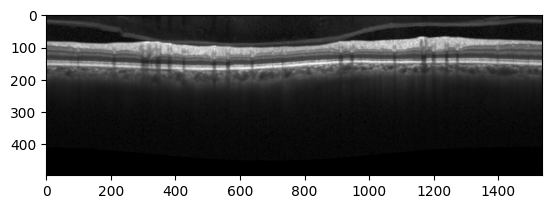

In [11]:
random_ind = np.random.randint(0,len(train_dataset))
tmp_img,tmp_lab = train_dataset.__getitem__(random_ind)
print("Caption : ",tmp_lab)
plt.imshow(tmp_img)
plt.show()

# Collate for batching..

In [12]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, ground_truth = example
        images.append(image)

        
        # hard-coded chat template
        prompt = f"USER: <image>\nDescribe the OCT scan in detail.\nASSISTANT: {ground_truth}"
        texts.append(prompt)

    # apply pre-processing function....
    batch = processor(text=texts, 
                      images=images, 
                      padding=True, 
                      truncation=True,
                      return_tensors="pt")
    
    # creation of labels...
    labels = batch["input_ids"].clone()
    # ignore padding token ids....
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    # extract & generate batched pairs....
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, labels

def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        prompt = f"USER: <image>\nDescribe the OCT scan in detail.\nASSISTANT:"
        texts.append(prompt)
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

# PL lightning module

In [13]:
class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             pixel_values=pixel_values,
                             labels=labels)
        loss = outputs.loss
        print(loss)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, 
                                            attention_mask=attention_mask,
                                            pixel_values=pixel_values, 
                                            max_new_tokens=MAX_LENGTH)
        
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], 
                                                  skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, 
                          collate_fn=train_collate_fn, 
                          batch_size=self.batch_size, 
                          shuffle=True, 
                          num_workers=4)

    def val_dataloader(self):
        return DataLoader(valid_dataset, 
                          collate_fn=eval_collate_fn, 
                          batch_size=self.batch_size, 
                          shuffle=False, 
                          num_workers=4)

In [14]:
config = {"max_epochs": 2,
          "val_check_interval": 0.95, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 1,
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,}

model_module = LlavaModelPLModule(config, processor, model)


early_stop_callback = EarlyStopping(monitor="val_edit_distance", 
                                    patience=3, 
                                    verbose=False, 
                                    mode="min")

# Final Training

In [ ]:
trainer = L.Trainer(accelerator="gpu",
                    devices=[0],
                    max_epochs=config.get("max_epochs"),
                    accumulate_grad_batches=config.get("accumulate_grad_batches"),
                    check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
                    gradient_clip_val=config.get("gradient_clip_val"),
                    precision="16-mixed",
                    limit_val_batches=5,
                    num_sanity_val_steps=0,
                    callbacks=[early_stop_callback])

trainer.fit(model_module)

/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/py ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------


Epoch 0:   0%|          | 0/841 [00:00<?, ?it/s] 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor(10.9105, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0: 100%|██████████| 841/841 [12:04<00:00,  1.16it/s, v_num=35]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


Prediction: Patient is a 58 year old Non-Hispanic, Black <SEX> with  with no eye disease.. IOP is 11.0 mmHg, CCT is 519.0 mm, spherical equivalent is -1.25 diopters. Patient has history of High Blood Pressure

ONH OCT is unusable due to quality and/or segmentation issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and infe

/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: Patient is a 58 year old Non-Hispanic, Black <SEX> with  with no eye disease.. IOP is 11.0 mmHg, CCT is 519.0 mm, spherical equivalent is -1.25 diopters. Patient has history of High Blood Pressure

ONH OCT is unusable due to quality and/or segmentation issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and inferior sector(s).

Structure - function correlation unknown because of OCT quality issues.

Patient has an MD = 0.81 dB (PSD = 1.13 dB) on recent, reliable 24-2 VF test. Functional loss in superior and infe